In [1]:
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import math
import os
import cv2
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.font_manager as fm

In [2]:
from utils.plot_fig import plot_lr_all_info, plot_static_semilogy
from utils.doubly_random_matrix import  get_strongly_connected_directed_row_column_stochastic_matrix
from utils.stepsize_alg import get_stepsize, get_beta1t
from utils.load_logistic_regression_data import (
    load_fashion_mnist_data
)
from utils.random_quantizer import probabilistic_quantizer
from utils.summary_writer import get_summary_writer
from utils.model_metrics import get_scores
from utils.data_recorder import IDTrainingRecorderForOne
from utils.degradation import (
    motion_blur,
    add_gaussian_noise,
    add_given_gaussian_noise
)
from utils.load_pics import (
    load_a_picture
)
from utils.timestamp import get_strftime
from utils.make_dirs import make_dir
from utils.image_calculate import default_generate_motion_blur_kernels,default_generate_gaussian_noise
from utils.trust_opinion import AgentsAggregation
from utils.proj import project_onto_sphere,project_onto_l2_ball

# 0 预备

In [3]:
# 设置字体优先级：中文用宋体，英文用 Times New Roman

plt.rcParams['font.sans-serif'] = ['Times New Roman']  # ✅ 宋体+Times New Roman
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示异常

# 指定中英文字体路径
chinese_font_path = 'C:/Windows/Fonts/simsun.ttc'  # 替换为你的宋体路径
english_font_path = 'C:/Windows/Fonts/times.ttf'   # 替换为 Times New Roman 路径

chinese_font = fm.FontProperties(fname=chinese_font_path)
english_font = fm.FontProperties(fname=english_font_path)

# 1 导入数据和算法

# 1.1 导入数据

In [4]:
# data_name="custom"
data_name="fashion_mnist"

In [5]:
if data_name=="custom":
    data_path=r".\data\test"
    pic_name="photographer.jpeg"
    # pic_name="ikun.jpg"
    (
        image,
        image_dim_x,
        image_dim_y,
        nums
    )=load_a_picture(data_path,pic_name,use_nomalization=True)
    images=[image]
    
elif data_name=="fashion_mnist":
    mnist_path = r".\data\fashion_mnist"
    (
        x_train,
        y_train,
        x_test,
        y_test,
        w_opt,
        lambda_val,
        dims,
        cls_nums,
        nums,
    ) = load_fashion_mnist_data(mnist_path,use_nomalization=False)

    print((dims, nums))
    image_dim_x=28
    image_dim_y=28
    # 将每张图片的数据重塑为28x28
    images = x_train.T.reshape(nums, image_dim_x, image_dim_y).astype(np.float32)

(784, 60000)


In [6]:
norm = Normalize(vmin=None, vmax=None)

# 1.2 导入算法

In [7]:
alg_table={
    "q-pdq":False,
    "dsgd":False,
    "q-dadam-ps":True,
    "dadam-ps":False,
    "gtadam":False,
}

# 2 初始化

## 2.1 初始化模型参数

In [8]:
np.random.seed(42)

In [9]:
w_init = np.random.randn(image_dim_x, image_dim_y)

In [10]:
w_init.shape

(28, 28)

In [11]:
lambda_param=0.01
# lambda_param=0
# lambda_param=0.01

In [12]:
non_convex_alpha=1e-3
non_convex_beta=1

In [13]:
# 实验图片数
pic_nums=6

In [14]:
test_image_nums=min(pic_nums,nums)

In [15]:
if data_name=="fashion_mnist":
    indices=np.random.choice(nums,size=test_image_nums,replace=False)
    images=images[indices]
    print(indices)

[14940 22500 35737 36211 43247  7652]


In [16]:
epsilon = 1e-5

In [17]:
# 最大迭代次数
if data_name == "custom":
    epoch_num = 500
elif data_name == "fashion_mnist":
    epoch_num = 5000

In [18]:
if data_name == "custom":
    agents_num = 32
elif data_name == "fashion_mnist":
    agents_num = 20

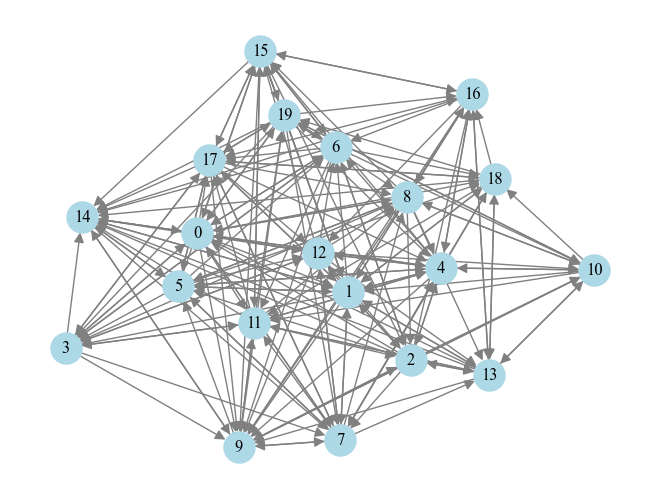

In [19]:
R,C = get_strongly_connected_directed_row_column_stochastic_matrix(agents_num,show=True)
net = C.T

In [20]:
net

array([[0.09090909, 0.        , 0.09090909, 0.09090909, 0.        ,
        0.        , 0.09090909, 0.09090909, 0.09090909, 0.        ,
        0.        , 0.        , 0.09090909, 0.09090909, 0.09090909,
        0.09090909, 0.        , 0.        , 0.        , 0.09090909],
       [0.07142857, 0.07142857, 0.07142857, 0.        , 0.07142857,
        0.07142857, 0.        , 0.07142857, 0.        , 0.        ,
        0.07142857, 0.        , 0.        , 0.07142857, 0.07142857,
        0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857],
       [0.        , 0.1       , 0.1       , 0.        , 0.1       ,
        0.        , 0.1       , 0.        , 0.1       , 0.1       ,
        0.        , 0.1       , 0.1       , 0.1       , 0.        ,
        0.1       , 0.        , 0.        , 0.        , 0.        ],
       [0.1       , 0.1       , 0.        , 0.1       , 0.        ,
        0.1       , 0.1       , 0.        , 0.1       , 0.        ,
        0.        , 0.1       , 0.1       , 0

## 2.2 设置图像劣化

In [21]:
use_given_noise=True

In [22]:
# 生成运动模糊卷积核
# motion_blur_kernel_ls=default_generate_motion_blur_kernels(agents_num,(image_dim_x,image_dim_y),strategy="variation")

# 以下配置适合在photographer中使用
# motion_blur_kernel_ls=default_generate_motion_blur_kernels(agents_num,(image_dim_x,image_dim_y),degrees_ls=None,angles_ls=None,strategy="range")

# degrees=[4+i%2 for i in range(agents_num)]
# angles = [2+i%2 for i in range(agents_num)]

degrees=list(range(1,agents_num+1))
angles = [math.floor(d * 0.1 % 3+1) for d in degrees]

motion_blur_kernel_ls=default_generate_motion_blur_kernels(agents_num,degrees_ls=degrees,angles_ls=angles,strategy="given")

if use_given_noise:
    gaussian_noise_ls=default_generate_gaussian_noise(agents_num,(image_dim_x,image_dim_y),mean=0,var=0.01)
else:
    gaussian_noise_ls=[None for i in range(agents_num)]

In [23]:
def image_degradation(img,motion_blur_kernel,gaussian_noise=None,add_noise=True):
    img_ = motion_blur(img,motion_blur_kernel)
    if add_noise:
        if gaussian_noise is None:
            gaussian_noise=default_generate_gaussian_noise(1,(image_dim_x,image_dim_y),mean=0,var=0.01)[0]
        img_ = add_given_gaussian_noise(img_,gaussian_noise)
    
    return img_

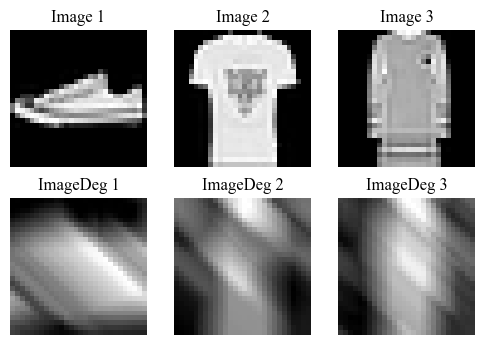

In [24]:
# 创建一个新的figure
plt.figure(figsize=(6, 4))
show_image_nums=min(min(3,nums),test_image_nums)
deblurring_index=min(agents_num-1,31)
# 显示前三张图片
for i in range(show_image_nums):
    plt.subplot(2, show_image_nums, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Image {i+1}')
    plt.axis('off')
    
    plt.subplot(2, show_image_nums, i+show_image_nums+1)
    plt.imshow(image_degradation(images[i],motion_blur_kernel_ls[deblurring_index],gaussian_noise_ls[deblurring_index]), cmap='gray')
    
    plt.title(f'ImageDeg {i+1}')
    plt.axis('off')

# 显示所有图像
plt.show()

## 2.3 设置损失函数

In [25]:
use_non_convex=False

In [26]:
def loss_fn(x, w, H,noise=None,lambda_param=lambda_param,use_non_convex=use_non_convex,non_convex_alpha=non_convex_alpha,non_convex_beta=non_convex_beta):

    Hixi=image_degradation(w,H,noise)
    yi=image_degradation(x,H,noise)

    loss = np.linalg.norm(Hixi-yi)**2 + (lambda_param/2)*np.linalg.norm(w,2)**2
    
    if use_non_convex:
        loss+=non_convex_alpha* np.sum(np.dot((non_convex_beta*w**2).T,1/(1+non_convex_beta*w**2)))
    return loss


In [27]:
def grad_fn(x, w, H,noise=None,lambda_param=lambda_param,use_non_convex=use_non_convex,non_convex_alpha=non_convex_alpha,non_convex_beta=non_convex_beta):

    Hixi=image_degradation(w,H,noise)
    yi=image_degradation(x,H,noise)


    g_f=2*cv2.filter2D((Hixi-yi), -1, H.T ) 

    g_norm= lambda_param*w

    g_non=0
    if use_non_convex:
        g_non= non_convex_alpha*np.multiply(2*non_convex_beta*w,(1+non_convex_beta*w**2)**(-2))

    return g_f+g_norm+g_non

In [28]:
def calculate_psnr(original, reconstructed):
    mse = mean_squared_error(original.flatten(), reconstructed.flatten())
    if mse == 0:  
        # MSE is zero means no noise is present in the signal.
        # Therefore PSNR have no importance.
        return float('inf')
    if np.max(original)>1.0:
        max_pixel = 225.0
    else:
        max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [29]:

def calculate_ssim(original, reconstructed):
    # Ensure the images are in the range [0, 255]
    original = original.astype(np.float64)
    reconstructed = reconstructed.astype(np.float64)
    ssim_value = ssim(original, reconstructed, data_range=original.max() - original.min())
    return ssim_value

In [30]:
test_image=image_degradation(images[0],motion_blur_kernel_ls[10],gaussian_noise_ls[10])

In [31]:
grad_fn(images[0],test_image,motion_blur_kernel_ls[10],gaussian_noise_ls[10]).shape

(28, 28)

In [32]:
loss_fn(images[0],test_image,motion_blur_kernel_ls[10],gaussian_noise_ls[10])

174504.29331242281

In [33]:
calculate_psnr(images[0], test_image)

12.743568846674297

In [34]:
calculate_ssim(images[0], test_image)

0.3141579188454402

In [35]:
quantizer=probabilistic_quantizer

## 2.4 初始化LRTrainingRecorder和SummaryWriter

In [36]:
training_recorder=IDTrainingRecorderForOne()

In [37]:
pics_save_path=os.path.join(f"./logs/qdadamPS_compare_image_deblurring_pics/{data_name}",get_strftime())
make_dir(pics_save_path)

In [38]:
writer = get_summary_writer(f"./logs/qdadamPS_compare_image_deblurring/{data_name}")
# pic_save_path = "./results/dadam_batch_size_1000"

## 2.5 保存劣化图像

Image1, psnr value:13.800595103887304
Image1, ssun value:0.38313803792484463
Image2, psnr value:11.926895835869548
Image2, ssun value:0.4749037294692838
Image3, psnr value:14.770747854966155
Image3, ssun value:0.47385126684074796
Image4, psnr value:13.84724732464643
Image4, ssun value:0.3360466826840898
Image5, psnr value:12.393572217427485
Image5, ssun value:0.4543097293429898
Image6, psnr value:13.440889585314812
Image6, ssun value:0.34837370004547463


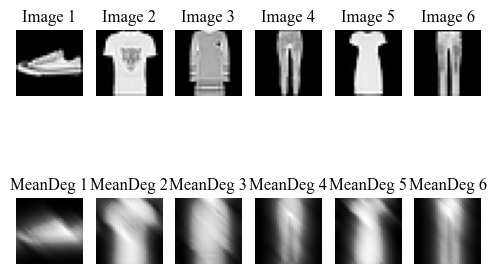

In [39]:
# 创建一个新的figure
plt.figure(figsize=(6, 4))
show_image_nums=min(pic_nums,nums)

for i in range(min(pic_nums,nums)):
    test_allw=[]
    for j in range(agents_num):
        test_allw.append(image_degradation(images[i],motion_blur_kernel_ls[j],gaussian_noise_ls[j]))
    test_meanw=np.mean(test_allw, axis=0)
    psnr_val=calculate_psnr(images[i], test_meanw)
    ssim_val=calculate_ssim(images[i], test_meanw)
    print(f"Image{i+1}, psnr value:{psnr_val}")
    print(f"Image{i+1}, ssun value:{ssim_val}")

    plt.subplot(2, show_image_nums, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Image {i+1}')
    plt.axis('off')
    
    plt.subplot(2, show_image_nums, i+show_image_nums+1)
    plt.imshow(test_meanw, cmap='gray')
    plt.title(f'MeanDeg {i+1}')

    plt.imsave(os.path.join(pics_save_path,f"image{i}-debluring.jpeg"),test_meanw,cmap="gray")
    plt.axis('off')
# 显示所有图像
plt.show()

# 3 Quantized Push-Sum模型训练

## 3.1 设置优化器初始参数

In [40]:

# 初始步长
step_init = 3
# eig返回元组，第一为特征值，第二为特征向量
# step_init=1-np.sort(np.linalg.eig(net)[0])[1]  # 选取第二特征值

In [41]:
batch_size=1

In [42]:
beta1t_lambda=0.9

## 3.2 初始化优化器

In [43]:
# w_init=test_meanw.copy()

In [44]:
kt_pow=1.5

## 3.3 模型训练

In [45]:
# 算法名称
alg_name="q-pdq"

In [46]:
if alg_table[alg_name]:
    for image_index in range(test_image_nums):
        # 记录初始状态
        pbar=tqdm(total=epoch_num)
        pbar.set_description('Image'+str(image_index))
        x_data = images[image_index]

        alg_label = f"method_{alg_name}_image_{image_index}_step_{step_init:.2f}_bs_{batch_size}_ktpow_{kt_pow}"
        # 初始化 训练过程记录
        training_recorder.init_alg_model(alg_label)

        # *************** 初始化开始 ***************
        w_node = np.zeros((agents_num, image_dim_x, image_dim_y))
        quanz_node=np.zeros((agents_num, image_dim_x, image_dim_y))

        x_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        x_prev_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        # x_hat_node 初始化为0
        x_hat_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        x_hat_prev_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        # y_node 初始化为1
        y_node=np.ones((agents_num, image_dim_x, image_dim_y))
        y_prev_node=np.ones((agents_num, image_dim_x, image_dim_y))
        z_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        for ii in range(agents_num):
            w_node[ii] = w_init.copy()
            quanz_node[ii]=quantizer(w_init,1)
            x_node[ii]=w_init.copy()
            x_prev_node[ii]=w_init.copy()
            z_node[ii]=w_init.copy()
        # *************** 初始化结束 ***************

        # 保存第一张图像
        w = np.mean(z_node,axis=0)
        plt.imsave(os.path.join(pics_save_path,f"{alg_name}_image{image_index}-epoch0.jpeg"),w,cmap="gray")
        plt.imsave(os.path.join(pics_save_path,f"{alg_name}_image{image_index}-origin.jpeg"),x_data,cmap="gray")
        # 记录
        training_recorder.auto_cal_and_append(alg_label,x_data,z_node,motion_blur_kernel_ls,gaussian_noise_ls,loss_fn,calculate_psnr,calculate_ssim)
        for i in range(epoch_num):
            pbar.update()
            kt=math.ceil((i+1)**kt_pow)

            x_prev_node=x_node.copy()
            x_hat_prev_node=x_hat_node.copy()
            y_prev_node=y_node.copy()

            step=get_stepsize(step_init,i+1,method="frac_sqrt_t")
            for ii in range(agents_num):
                # 对权重进行量化
                quanz_node[ii]=quantizer(x_prev_node[ii]-x_hat_prev_node[ii],kt,use_quantize=True)
                x_hat_node[ii]=x_hat_prev_node[ii]+quanz_node[ii]

                w_consen_node = x_prev_node[ii]-x_hat_node[ii]
                for jj in range(agents_num):
                    w_consen_node = w_consen_node + net[ii, jj] * x_hat_node[jj]
                w_node[ii] =w_consen_node

                y_consen_node=np.zeros(w_init.shape)
                for jj in range(agents_num):
                    y_consen_node=y_consen_node+net[ii,jj]*y_prev_node[ii]
                y_node[ii]=y_consen_node

                z_node[ii]=w_node[ii]/y_node[ii]
            
                # 梯度下降函数更新W权重
                grad = grad_fn(x_data, z_node[ii],motion_blur_kernel_ls[ii],gaussian_noise_ls[ii])
                x_node[ii]=w_node[ii]-step*grad
                
                # x_prev_node[ii]=x_node[ii].copy()
                # x_hat_prev_node[ii]=x_hat_node[ii].copy()
                # y_prev_node[ii]=y_node[ii].copy()

            w = np.mean(z_node,axis=0)

            # 记录
            training_recorder.auto_cal_and_append(alg_label,x_data,z_node,motion_blur_kernel_ls,gaussian_noise_ls,loss_fn,calculate_psnr,calculate_ssim)
            #设置进度条右边显示的信息   	
            pbar.set_postfix(loss=training_recorder.get_data_by_measure_and_alg_label('loss',alg_label)[i],
                             psnr=training_recorder.get_data_by_measure_and_alg_label('psnr',alg_label)[i],
                             ssim=training_recorder.get_data_by_measure_and_alg_label('ssim',alg_label)[i],
                             gen=i+1)	
            # if (i+1)%10==0:
            if (i+1)%50==0:
                plt.imsave(os.path.join(pics_save_path,f"{alg_name}_image{image_index}-epoch{i+1}.jpeg"),w,cmap="gray")



## 3.4 结果展示

In [47]:
def print_psnr_ssim(alg_name):
    if alg_table[alg_name]:
        # 导出所有数据，并绘制到tensorboard
        recorded_data=training_recorder.get_all_data_for_writer_scalars()
        if len(recorded_data["psnr"])>0:
            for info,val in recorded_data["psnr"][-1].items():
                if alg_name in info:
                    print(f"{info}: {val}")
            print("--------------------------------------------------------------")
            for info,val in recorded_data["ssim"][-1].items():
                if alg_name in info:
                    print(f"{info}: {val}")

In [48]:
print_psnr_ssim(alg_name)

# 4 DSGD 模型训练

## 4.1 设置优化器初始参数

In [49]:

# 初始步长
step_init = 0.1
# eig返回元组，第一为特征值，第二为特征向量
# step_init=1-np.sort(np.linalg.eig(net)[0])[1]  # 选取第二特征值

In [50]:
beta1t_lambda=0.9

## 4.2 初始化优化器

## 4.3 模型训练

In [51]:
# 算法名称
alg_name="dsgd"

In [52]:
if alg_table[alg_name]:  
    for image_index in range(test_image_nums):
        # 记录初始状态
        pbar=tqdm(total=epoch_num)
        pbar.set_description('Image'+str(image_index))
        x_data = images[image_index]
        alg_label = f"method_{alg_name}_image_{image_index}_step_{step_init:.2f}_bs_{batch_size}_ktpow_{kt_pow}"
        # 初始化 训练过程记录
        training_recorder.init_alg_model(alg_label)

        # *************** 初始化开始 ***************
        w_node = np.zeros((agents_num, image_dim_x, image_dim_y))
        for ii in range(agents_num):
            w_node[ii] = w_init.copy()
            # w_node[ii] = test_meanw.copy()
        # *************** 初始化结束 ***************
        # 保存第一张图像
        w = np.mean(w_node,axis=0)
        plt.imsave(os.path.join(pics_save_path,f"{alg_name}_image{image_index}-epoch0.jpeg"),w,cmap="gray")
        plt.imsave(os.path.join(pics_save_path,f"{alg_name}_image{image_index}-origin.jpeg"),x_data,cmap="gray")
        # 记录
        training_recorder.auto_cal_and_append(alg_label,x_data,w_node,motion_blur_kernel_ls,gaussian_noise_ls,loss_fn,calculate_psnr,calculate_ssim)
        for i in range(epoch_num):
            pbar.update()
            w_node_prev = w_node.copy()
            step=get_stepsize(step_init,i+1,method="decay-sq")
            for ii in range(agents_num):
                # 梯度下降函数更新W权重
                grad = grad_fn(x_data, w_node[ii],motion_blur_kernel_ls[ii],gaussian_noise_ls[ii])
                
                # consen
                w_consen_node = np.zeros(w_init.shape)
                for jj in range(agents_num):
                    w_consen_node = w_consen_node + net[ii, jj] * w_node_prev[jj]
                w_node[ii] =w_consen_node - step * grad

            w = np.mean(w_node,axis=0)
            # 记录
            training_recorder.auto_cal_and_append(alg_label,x_data,w_node,motion_blur_kernel_ls,gaussian_noise_ls,loss_fn,calculate_psnr,calculate_ssim)
            #设置进度条右边显示的信息   	
            pbar.set_postfix(loss=training_recorder.get_data_by_measure_and_alg_label('loss',alg_label)[i],gen=i+1)	
            
            if (i+1)%50==0:
                plt.imsave(os.path.join(pics_save_path,f"{alg_name}_image{image_index}-epoch{i+1}.jpeg"),w,cmap="gray")



## 4.4 展示结果

In [53]:
print_psnr_ssim(alg_name)

In [54]:
if alg_table[alg_name]:
    # 创建一个新的figure
    plt.figure(figsize=(6, 4))
    show_image_nums=min(3,nums)
    deblurring_index=31
    # 显示前三张图片
    for i in range(show_image_nums):
        plt.subplot(2, show_image_nums, i+1)
        plt.imshow(w, cmap='gray')
        plt.title(f'Image {i+1}')
        plt.axis('off')
        
        plt.subplot(2, show_image_nums, i+show_image_nums+1)
        plt.imshow(image_degradation(w,motion_blur_kernel_ls[deblurring_index],gaussian_noise_ls[deblurring_index]), cmap='gray')
        
        plt.title(f'ImageDeg {i+1}')
        plt.axis('off')

    # 显示所有图像
    plt.show()

# 5 Q-DADAM Push-Sum 算法训练

## 5.1 设置优化器初始参数

In [55]:

# 初始步长
step_init = 30
# eig返回元组，第一为特征值，第二为特征向量
# step_init=1-np.sort(np.linalg.eig(net)[0])[1]  # 选取第二特征值
beta1 = 0.9
beta2 = 0.999
beta3 = 0.9
G0=1e-3
beta1t_lambda=0.9

In [56]:
batch_size=1

In [57]:
beta1t_lambda=0.9

## 5.2 初始化优化器

In [58]:
kt_pow=1.5

## 5.3 模型训练

In [59]:
# 算法名称
alg_name="q-dadam-ps"

In [60]:
if alg_table[alg_name]:
    for image_index in range(test_image_nums):
        # 记录初始状态
        pbar=tqdm(total=epoch_num)
        pbar.set_description('Image'+str(image_index))
        x_data = images[image_index]

        alg_label = f"method_{alg_name}_image_{image_index}_step_{step_init:.2f}_bs_{batch_size}_ktpow_{kt_pow}"
        # 初始化 训练过程记录
        training_recorder.init_alg_model(alg_label)

        # *************** 初始化开始 ***************
        w_node = np.zeros((agents_num, image_dim_x, image_dim_y))

        x_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        x_prev_node=np.zeros((agents_num, image_dim_x, image_dim_y))

        quant_x_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        quant_x_prev_node=np.zeros((agents_num, image_dim_x, image_dim_y))

        m_node = np.zeros((agents_num, image_dim_x, image_dim_y))
        v_node = np.zeros((agents_num, image_dim_x, image_dim_y))
        m_hat_node = np.zeros((agents_num, image_dim_x, image_dim_y))
        v_hat_node = np.zeros((agents_num, image_dim_x, image_dim_y))
        v_bar_node = np.zeros((agents_num, image_dim_x, image_dim_y))
        v_bar_prev_node = G0**2 * np.ones((agents_num, image_dim_x, image_dim_y))

        # x_hat_node 初始化为0
        x_hat_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        x_hat_prev_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        # y_node 初始化为1
        y_node=np.ones((agents_num, image_dim_x, image_dim_y))
        y_prev_node=np.ones((agents_num, image_dim_x, image_dim_y))
        z_node=np.zeros((agents_num, image_dim_x, image_dim_y))

        for ii in range(agents_num):
            w_node[ii] = w_init.copy()
            quant_x_node[ii]=quantizer(w_init,1)

            x_node[ii]=w_init.copy()
            x_prev_node[ii]=w_init.copy()

            z_node[ii]=w_init.copy()
        # *************** 初始化结束 ***************

        total_iter=0

        # 保存第一张图像
        w = np.mean(z_node,axis=0)
        plt.imsave(os.path.join(pics_save_path,f"{alg_name}_image{image_index}-epoch0.jpeg"),w,cmap="gray")
        plt.imsave(os.path.join(pics_save_path,f"{alg_name}_image{image_index}-origin.jpeg"),x_data,cmap="gray")
        # 记录
        training_recorder.auto_cal_and_append(alg_label,x_data,z_node,motion_blur_kernel_ls,gaussian_noise_ls,loss_fn,calculate_psnr,calculate_ssim)
        for i in range(epoch_num):
            pbar.update()
            total_iter = total_iter + 1

            kt=math.ceil((i+1)**kt_pow)
            beta1t=get_beta1t(beta1,total_iter,lambda_val=beta1t_lambda)

            x_prev_node=x_node.copy()
            x_hat_prev_node=x_hat_node.copy()
            y_prev_node=y_node.copy()

            step=get_stepsize(step_init,i+1,method="decay-sq")
            for ii in range(agents_num):

                # 对权重进行量化
                w_consen_node = np.zeros(w_init.shape)
                for jj in range(agents_num):
                    w_consen_node = w_consen_node + net[ii,jj] * quantizer(x_prev_node[jj],kt=kt,use_quantize=True)
                w_node[ii] = w_consen_node

                y_consen_node=np.zeros(w_init.shape)
                for jj in range(agents_num):
                    y_consen_node=y_consen_node+net[ii,jj]*y_prev_node[jj]
                y_node[ii]=y_consen_node
                y_prev_node[ii]=y_node[ii].copy()

                z_node[ii]=w_node[ii]/y_node[ii]
                
               # 梯度下降函数更新W权重
                grad = grad_fn(x_data, z_node[ii],motion_blur_kernel_ls[ii],gaussian_noise_ls[ii])
                # 加入DADAM
                m_node[ii] = (
                    beta1t * m_node[ii] + (1 - beta1t) * grad
                )  # update biased first moment estimate
                v_node[ii] = beta2 * v_node[ii] + (1 - beta2) * np.power(
                    grad, 2
                )  # update biased second raw moment estimate

                m_hat_node[ii] = m_node[ii] / (
                    1 - beta1t**total_iter
                )  # compute bias-corrected fist moment estimate
                v_hat_node[ii] = v_node[ii] / (
                    1 - beta2**total_iter
                )  # compute bias-corrected second raw moment estimate

                v_bar_node[ii] = beta3 * v_bar_prev_node[ii] + (1 - beta3) * np.where(
                v_hat_node[ii]>v_bar_prev_node[ii], v_hat_node[ii],v_bar_prev_node[ii])  # normalize second raw moment

                v_bar_prev_node[ii]=v_bar_node[ii].copy()       

                x_node[ii] = w_node[ii] - step * m_hat_node[ii] / (
                np.sqrt(v_bar_node[ii] )+ epsilon
                )
                x_prev_node[ii]=x_node[ii].copy()


            w = np.mean(z_node,axis=0)

            # 记录
            training_recorder.auto_cal_and_append(alg_label,x_data,z_node,motion_blur_kernel_ls,gaussian_noise_ls,loss_fn,calculate_psnr,calculate_ssim)
            #设置进度条右边显示的信息   	
            pbar.set_postfix(loss=training_recorder.get_data_by_measure_and_alg_label('loss',alg_label)[i],
                             psnr=training_recorder.get_data_by_measure_and_alg_label('psnr',alg_label)[i],
                             ssim=training_recorder.get_data_by_measure_and_alg_label('ssim',alg_label)[i],gen=i+1)	
            # if (i+1)%10==0:
            if (i+1)%50==0:
                plt.imsave(os.path.join(pics_save_path,f"{alg_name}_image{image_index}-epoch{i+1}.jpeg"),w,cmap="gray")



Image4: 100%|██████████| 5000/5000 [02:01<00:00, 41.32it/s, gen=5000, loss=1.47e+6, psnr=31.1, ssim=0.961]


## 5.4 结果展示

In [61]:
print_psnr_ssim(alg_name)

method_q-dadam-ps_image_0_step_30.00_bs_1_ktpow_1.5: 27.351922036774386
method_q-dadam-ps_image_1_step_30.00_bs_1_ktpow_1.5: 31.346809261696173
method_q-dadam-ps_image_2_step_30.00_bs_1_ktpow_1.5: 33.47475541318555
method_q-dadam-ps_image_3_step_30.00_bs_1_ktpow_1.5: 27.50976922541165
method_q-dadam-ps_image_4_step_30.00_bs_1_ktpow_1.5: 31.05184706585087
method_q-dadam-ps_image_5_step_30.00_bs_1_ktpow_1.5: 26.180364838338622
--------------------------------------------------------------
method_q-dadam-ps_image_0_step_30.00_bs_1_ktpow_1.5: 0.9467835337946684
method_q-dadam-ps_image_1_step_30.00_bs_1_ktpow_1.5: 0.9788815281082381
method_q-dadam-ps_image_2_step_30.00_bs_1_ktpow_1.5: 0.9918797188086906
method_q-dadam-ps_image_3_step_30.00_bs_1_ktpow_1.5: 0.9355123065287336
method_q-dadam-ps_image_4_step_30.00_bs_1_ktpow_1.5: 0.9610912288739942
method_q-dadam-ps_image_5_step_30.00_bs_1_ktpow_1.5: 0.935098328463143


# 6 DADAM Push-Sum 算法训练

## 6.1 设置优化器初始参数

In [62]:

# 初始步长
step_init = 1
# eig返回元组，第一为特征值，第二为特征向量
# step_init=1-np.sort(np.linalg.eig(net)[0])[1]  # 选取第二特征值
beta1 = 0.9
beta2 = 0.999
beta3 = 0.9
G0=1e-3
beta1t_lambda=0.9

In [63]:
batch_size=1

In [64]:
beta1t_lambda=0.9

## 6.2 初始化优化器

In [65]:
kt_pow=1.5

## 6.3 模型训练

In [66]:
# 算法名称
alg_name="dadam-ps"

In [67]:
if alg_table[alg_name]:
    for image_index in range(test_image_nums):
        # 记录初始状态
        pbar=tqdm(total=epoch_num)
        pbar.set_description('Image'+str(image_index))
        x_data = images[image_index]

        alg_label = f"method_{alg_name}_image_{image_index}_step_{step_init:.2f}_bs_{batch_size}_ktpow_{kt_pow}"
        # 初始化 训练过程记录
        training_recorder.init_alg_model(alg_label)

        # *************** 初始化开始 ***************
        w_node = np.zeros((agents_num, image_dim_x, image_dim_y))

        x_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        x_prev_node=np.zeros((agents_num, image_dim_x, image_dim_y))

        quant_x_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        quant_x_prev_node=np.zeros((agents_num, image_dim_x, image_dim_y))

        m_node = np.zeros((agents_num, image_dim_x, image_dim_y))
        v_node = np.zeros((agents_num, image_dim_x, image_dim_y))
        m_hat_node = np.zeros((agents_num, image_dim_x, image_dim_y))
        v_hat_node = np.zeros((agents_num, image_dim_x, image_dim_y))
        v_bar_node = np.zeros((agents_num, image_dim_x, image_dim_y))
        v_bar_prev_node = G0**2 * np.ones((agents_num, image_dim_x, image_dim_y))

        # x_hat_node 初始化为0
        x_hat_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        x_hat_prev_node=np.zeros((agents_num, image_dim_x, image_dim_y))
        # y_node 初始化为1
        y_node=np.ones((agents_num, image_dim_x, image_dim_y))
        y_prev_node=np.ones((agents_num, image_dim_x, image_dim_y))
        z_node=np.zeros((agents_num, image_dim_x, image_dim_y))

        for ii in range(agents_num):
            w_node[ii] = w_init.copy()
            quant_x_node[ii]=quantizer(w_init,1)

            x_node[ii]=w_init.copy()
            x_prev_node[ii]=w_init.copy()

            z_node[ii]=w_init.copy()
        # *************** 初始化结束 ***************

        total_iter=0

        # 保存第一张图像
        w = np.mean(z_node,axis=0)
        plt.imsave(os.path.join(pics_save_path,f"{alg_name}_image{image_index}-epoch0.jpeg"),w,cmap="gray")
        plt.imsave(os.path.join(pics_save_path,f"{alg_name}_image{image_index}-origin.jpeg"),x_data,cmap="gray")
        # 记录
        training_recorder.auto_cal_and_append(alg_label,x_data,z_node,motion_blur_kernel_ls,gaussian_noise_ls,loss_fn,calculate_psnr,calculate_ssim)
        for i in range(epoch_num):
            pbar.update()
            total_iter = total_iter + 1

            kt=math.ceil((i+1)**kt_pow)
            beta1t=get_beta1t(beta1,total_iter,lambda_val=beta1t_lambda)

            x_prev_node=x_node.copy()
            x_hat_prev_node=x_hat_node.copy()
            y_prev_node=y_node.copy()

            step=get_stepsize(step_init,i+1,method="decay-sq")
            for ii in range(agents_num):

                # 对权重进行量化
                w_consen_node = np.zeros(w_init.shape)
                for jj in range(agents_num):
                    w_consen_node = w_consen_node + net[ii,jj] * x_prev_node[jj]
                w_node[ii] = w_consen_node

                y_consen_node=np.zeros(w_init.shape)
                for jj in range(agents_num):
                    y_consen_node=y_consen_node+net[ii,jj]*y_prev_node[jj]
                y_node[ii]=y_consen_node
                y_prev_node[ii]=y_node[ii].copy()

                z_node[ii]=w_node[ii]/y_node[ii]
                
               # 梯度下降函数更新W权重
                grad = grad_fn(x_data, z_node[ii],motion_blur_kernel_ls[ii],gaussian_noise_ls[ii])
                # 加入DADAM
                m_node[ii] = (
                    beta1t * m_node[ii] + (1 - beta1t) * grad
                )  # update biased first moment estimate
                v_node[ii] = beta2 * v_node[ii] + (1 - beta2) * np.power(
                    grad, 2
                )  # update biased second raw moment estimate

                m_hat_node[ii] = m_node[ii] / (
                    1 - beta1t**total_iter
                )  # compute bias-corrected fist moment estimate
                v_hat_node[ii] = v_node[ii] / (
                    1 - beta2**total_iter
                )  # compute bias-corrected second raw moment estimate

                v_bar_node[ii] = beta3 * v_bar_prev_node[ii] + (1 - beta3) * np.where(
                v_hat_node[ii]>v_bar_prev_node[ii], v_hat_node[ii],v_bar_prev_node[ii])  # normalize second raw moment

                v_bar_prev_node[ii]=v_bar_node[ii].copy()       

                x_node[ii] = w_node[ii] - step * m_hat_node[ii] / (
                np.sqrt(v_bar_node[ii] )+ epsilon
                )
                x_prev_node[ii]=x_node[ii].copy()


            w = np.mean(z_node,axis=0)

            # 记录
            training_recorder.auto_cal_and_append(alg_label,x_data,z_node,motion_blur_kernel_ls,gaussian_noise_ls,loss_fn,calculate_psnr,calculate_ssim)
            #设置进度条右边显示的信息   	
            pbar.set_postfix(loss=training_recorder.get_data_by_measure_and_alg_label('loss',alg_label)[i],gen=i+1)	
            # if (i+1)%10==0:
            if (i+1)%50==0:
                plt.imsave(os.path.join(pics_save_path,f"{alg_name}_image{image_index}-epoch{i+1}.jpeg"),w,cmap="gray")



## 6.4 结果展示

In [68]:
print_psnr_ssim(alg_name)

# 数据处理

In [69]:
# 导出所有数据，并绘制到tensorboard
recorded_data=training_recorder.get_all_data_for_writer_scalars()
for measure,recorder_ls in recorded_data.items():
    epoch=0
    for d in recorder_ls:
        writer.add_scalars(measure,d,epoch)
        epoch=epoch+1

In [70]:
recorded_data.keys()

dict_keys(['lossopt', 'loss', 'regret', 'psnr', 'ssim'])

In [71]:
recorded_data["psnr"]

[{'method_q-dadam-ps_image_0_step_30.00_bs_1_ktpow_1.5': 7.522227241694085,
  'method_q-dadam-ps_image_1_step_30.00_bs_1_ktpow_1.5': 2.8303046815642503,
  'method_q-dadam-ps_image_2_step_30.00_bs_1_ktpow_1.5': 5.09636426284974,
  'method_q-dadam-ps_image_3_step_30.00_bs_1_ktpow_1.5': 7.88163329175796,
  'method_q-dadam-ps_image_4_step_30.00_bs_1_ktpow_1.5': 4.049678452984491,
  'method_q-dadam-ps_image_5_step_30.00_bs_1_ktpow_1.5': 7.410815505110353},
 {'method_q-dadam-ps_image_0_step_30.00_bs_1_ktpow_1.5': 8.967782071616831,
  'method_q-dadam-ps_image_1_step_30.00_bs_1_ktpow_1.5': 4.169603663101845,
  'method_q-dadam-ps_image_2_step_30.00_bs_1_ktpow_1.5': 6.830972069543083,
  'method_q-dadam-ps_image_3_step_30.00_bs_1_ktpow_1.5': 9.540587098778776,
  'method_q-dadam-ps_image_4_step_30.00_bs_1_ktpow_1.5': 5.334515563724408,
  'method_q-dadam-ps_image_5_step_30.00_bs_1_ktpow_1.5': 9.00693916786701},
 {'method_q-dadam-ps_image_0_step_30.00_bs_1_ktpow_1.5': 11.109444066330754,
  'method_q

In [72]:
record_psnr_dict = {

}

for item in recorded_data["psnr"]:
    for key, value in item.items():
        # 解析键名结构 method_q-dadam-ps_image_0_step_1.00_bs_1_ktpow_1.5
        index = key.split("_")[3]  # 提取核心方法名
        if int(index) in record_psnr_dict:
            record_psnr_dict[int(index)].append(value)
        else:
            record_psnr_dict[int(index)]=[]

In [73]:
record_ssim_dict = {
    
}

for item in recorded_data["ssim"]:
    for key, value in item.items():
        # 解析键名结构 method_q-dadam-ps_image_0_step_1.00_bs_1_ktpow_1.5
        index = key.split("_")[3]  # 提取核心方法名
        if int(index) in record_ssim_dict:
            record_ssim_dict[int(index)].append(value)
        else:
            record_ssim_dict[int(index)]=[]

In [74]:
def smoothing(x ,smooth=0.99):
    """
    The smoothing function takes in a list of numbers and returns the same list with each number replaced by
    the average of itself and all previous numbers. The optional argument smooth is used to determine how much weight
    to give to the previous values, with 0 being no weight at all (i.e., just return the original array) and 1 giving
    equal weight to all values.

    :param x: Pass the data to be smoothed
    :param smooth: Control the amount of smoothing
    :return: A new array with the smoothed values
    :doc-author: Trelent
    """
    x = x.copy()
    weight = smooth
    for i in range(1 ,len(x)):
        x[i] = (x[ i -1] * weight + x[i]) / (weight + 1)
        weight = (weight + 1) * smooth
    return x

### 中文绘图

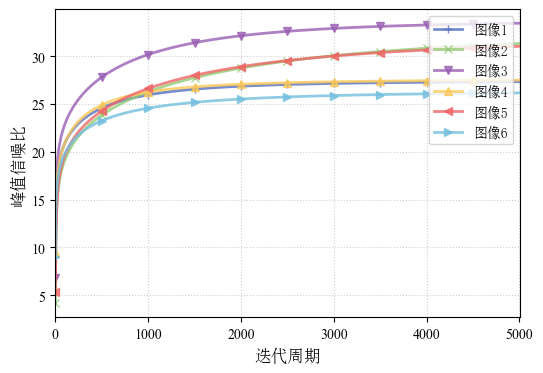

In [75]:
color_ls = ["5470C6","91CC75","9A60B4","FAC858","EE6666","73C0DE","3BA272","FC8452"]
marker_ls=["+", "x","v", "^", "<", ">", "1",]

name_dict={
    "q-pdq":"QPS-DO",
    "q-dadam-ps":"QPS-DADAM",  # PS-QDADAM: Push-Sum based Quantized Distributed ADAM
    "dadam-ps":"PS-DADAM",
}

fig, ax1 = plt.subplots(
        figsize=(6, 4),
        sharex=True,
    )
    

for idx,key in enumerate(record_psnr_dict):
    ls=record_psnr_dict[key]
    measure_data_len=len(ls)
    # marker个数
    marker_num=10
    ax1.plot( smoothing(ls,smooth=0.6),  linewidth=2, 
             color='#'+color_ls[idx],
             marker=f"{marker_ls[idx]}",
             markevery=int(measure_data_len / marker_num),
                alpha=0.8, label=f"图像{key+1}")
ax1.set_xlabel('迭代周期', fontsize=12, fontproperties=chinese_font)
ax1.set_ylabel('峰值信噪比', fontsize=12, fontproperties=chinese_font)
ax1.set_xlim(0, int(measure_data_len*1.002))
ax1.legend(loc='upper right',prop=chinese_font)
ax1.grid(True, linestyle=':', alpha=0.6)

ext="png"
fig.savefig(
    fname=f"figs/psnr-compare-q-dadam-ps-img-debluring-{data_name}.png",
    format=ext,
    bbox_inches='tight',
    dpi=300,  # ✅ 分辨率倍增
    pad_inches=0.1,  # ✅ 边界留白
    facecolor='auto',  # ✅ 自动背景填充
    metadata={'Creator': ''},  # ✅ 清除元数据
    quality=95 if ext == 'jpg' else None  # ✅ 格式定制
)


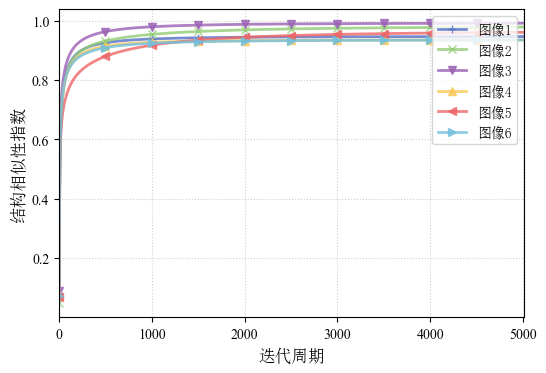

In [76]:

color_ls = ["5470C6","91CC75","9A60B4","FAC858","EE6666","73C0DE","3BA272","FC8452"]
marker_ls=["+", "x","v", "^", "<", ">", "1",]

fig, ax1 = plt.subplots(
        figsize=(6, 4),
        sharex=True,
    )
    
# ------ 子图1：真实信号观测 ------
for idx,key in enumerate(record_ssim_dict):
    ls=record_ssim_dict[key]
    measure_data_len=len(ls)
    # marker个数
    marker_num=10
    ax1.plot( smoothing(ls,smooth=0.6),  linewidth=2, 
             color='#'+color_ls[idx],
             marker=f"{marker_ls[idx]}",
             markevery=int(measure_data_len / marker_num),
                alpha=0.8, label=f"图像{key+1}")
ax1.set_xlabel('迭代周期', fontsize=12, fontproperties=chinese_font)
ax1.set_ylabel('结构相似性指数', fontsize=12 ,fontproperties=chinese_font)
ax1.set_xlim(0, int(measure_data_len*1.002))
ax1.legend(loc='upper right',prop=chinese_font)
ax1.grid(True, linestyle=':', alpha=0.6)

ext="png"
fig.savefig(
    fname=f"figs/ssim-compare-q-dadam-ps-img-debluring-{data_name}.png",
    format=ext,
    bbox_inches='tight',
    dpi=300,  # ✅ 分辨率倍增
    pad_inches=0.1,  # ✅ 边界留白
    facecolor='auto',  # ✅ 自动背景填充
    metadata={'Creator': ''},  # ✅ 清除元数据
    quality=95 if ext == 'jpg' else None  # ✅ 格式定制
)


### 英文绘图

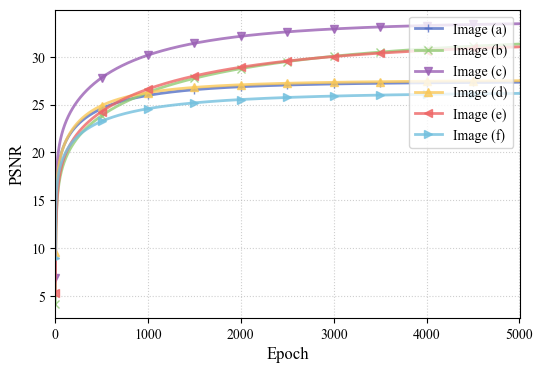

In [77]:
color_ls = ["5470C6","91CC75","9A60B4","FAC858","EE6666","73C0DE","3BA272","FC8452"]
marker_ls=["+", "x","v", "^", "<", ">", "1",]


fig, ax1 = plt.subplots(
        figsize=(6, 4),
        sharex=True,
    )
    

for idx,key in enumerate(record_psnr_dict):
    ls=record_psnr_dict[key]
    measure_data_len=len(ls)
    # marker个数
    marker_num=10
    ax1.plot( smoothing(ls,smooth=0.6),  linewidth=2, 
             color='#'+color_ls[idx],
             marker=f"{marker_ls[idx]}",
             markevery=int(measure_data_len / marker_num),
                alpha=0.8, label=f"Image ({chr(key+97)})")
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('PSNR', fontsize=12)
ax1.set_xlim(0, int(measure_data_len*1.002))
ax1.legend(loc='upper right')
ax1.grid(True, linestyle=':', alpha=0.6)

ext="pdf"
fig.savefig(
    fname=f"figs_en/psnr-compare-q-dadam-ps-img-debluring-{data_name}_en.pdf",
    format=ext,
    bbox_inches='tight',
    dpi=300,  # ✅ 分辨率倍增
    pad_inches=0.1,  # ✅ 边界留白
    facecolor='auto',  # ✅ 自动背景填充
    metadata={'Creator': ''},  # ✅ 清除元数据
    quality=95 if ext == 'jpg' else None  # ✅ 格式定制
)


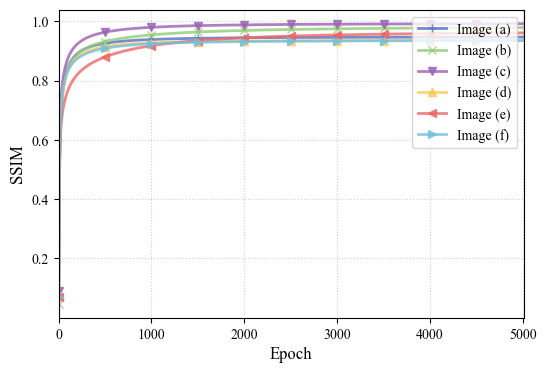

In [78]:

color_ls = ["5470C6","91CC75","9A60B4","FAC858","EE6666","73C0DE","3BA272","FC8452"]
marker_ls=["+", "x","v", "^", "<", ">", "1",]

name_dict={
    "q-pdq":"QPS-DO",
    "q-dadam-ps":"QPS-DADAM",  # PS-QDADAM: Push-Sum based Quantized Distributed ADAM
    "dadam-ps":"PS-DADAM",
    "kq-dadam-ps":"KQPS-DADAM",
}

fig, ax1 = plt.subplots(
        figsize=(6, 4),
        sharex=True,
    )
    
# ------ 子图1：真实信号观测 ------
for idx,key in enumerate(record_ssim_dict):
    ls=record_ssim_dict[key]
    measure_data_len=len(ls)
    # marker个数
    marker_num=10
    ax1.plot( smoothing(ls,smooth=0.6),  linewidth=2, 
             color='#'+color_ls[idx],
             marker=f"{marker_ls[idx]}",
             markevery=int(measure_data_len / marker_num),
                alpha=0.8, label=f"Image ({chr(key+97)})")
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('SSIM', fontsize=12)
ax1.set_xlim(0, int(measure_data_len*1.002))
ax1.legend(loc='upper right')
ax1.grid(True, linestyle=':', alpha=0.6)

ext="pdf"
fig.savefig(
    fname=f"figs_en/ssim-compare-q-dadam-ps-img-debluring-{data_name}_en.pdf",
    format=ext,
    bbox_inches='tight',
    dpi=300,  # ✅ 分辨率倍增
    pad_inches=0.1,  # ✅ 边界留白
    facecolor='auto',  # ✅ 自动背景填充
    metadata={'Creator': ''},  # ✅ 清除元数据
    quality=95 if ext == 'jpg' else None  # ✅ 格式定制
)
